## CESM2 - LARGE ENSEMBLE (LENS2)

#### by Mauricio Rocha and Dr. Gustavo Marques

- This notebooks servers as an example on how to extract surface (or any other 2D spatial field) properties from a selected spacial region accross all LENS2 members for the atmosphere component. 

## Imports

In [1]:
import intake
import intake_esm
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import fsspec
import cmocean
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import pop_tools
import sys
from distributed import Client
from ncar_jobqueue import NCARCluster
sys.path.append('../functions')
import util
from cartopy.util import add_cyclic_point
from misc import get_ij
import warnings, getpass, os

ERROR 1: PROJ: proj_create_from_database: Open of /glade/u/apps/opt/conda/envs/npl-2022b/share/proj failed


<div class="alert alert-block alert-info">
<b>Note:</b> comment the following line when debugging
</div>

In [2]:
warnings.filterwarnings("ignore")

### Local functions

### Dask workers

In [3]:
mem_per_worker = 120 # in GB 
num_workers = 80 
cluster = NCARCluster(cores=4, processes=3, memory=f'{mem_per_worker} GB',resource_spec=f'select=1:ncpus=6:mem={mem_per_worker}GB')
cluster.scale(num_workers)
client = Client(cluster)
print(client)
client

<Client: 'tcp://10.12.206.15:38357' processes=0 threads=0, memory=0 B>


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mauricio/mrocha/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mauricio/mrocha/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.15:38357,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mauricio/mrocha/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Data Ingest

In [4]:
%%time
catalog = intake.open_esm_datastore(
    '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'
)

CPU times: user 26.5 s, sys: 1.7 s, total: 28.2 s
Wall time: 28.8 s


In [5]:
catalog.search(component='atm').unique('frequency')

{'frequency': {'count': 5,
  'values': ['hour_6', 'month_1', 'hour_1', 'hour_3', 'day_1']}}

### Let's search for variables with montly frequency

In [6]:
cat_subset = catalog.search(component='atm',
                            frequency='month_1',
                            variable=['SHFLX','LHFLX','SST','PRECT']) # Sensible Heat Flux, Latent Heat Flux, Sea Surface Temperature, Total (Convective and large-scale) precipitation rate

In [7]:
%%time
dset_dict_raw = cat_subset.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 1min 53s, sys: 3.36 s, total: 1min 56s
Wall time: 2min 14s


In [8]:
# print keys
[key for key in dset_dict_raw.keys()]

['atm.ssp370.cam.h0.smbb.PRECT',
 'atm.historical.cam.h0.cmip6.SHFLX',
 'atm.historical.cam.h0.cmip6.SST',
 'atm.historical.cam.h0.smbb.SHFLX',
 'atm.ssp370.cam.h0.cmip6.LHFLX',
 'atm.historical.cam.h0.smbb.LHFLX',
 'atm.ssp370.cam.h0.smbb.SHFLX',
 'atm.historical.cam.h0.smbb.SST',
 'atm.ssp370.cam.h0.cmip6.PRECT',
 'atm.ssp370.cam.h0.smbb.SST',
 'atm.historical.cam.h0.cmip6.LHFLX',
 'atm.ssp370.cam.h0.smbb.LHFLX',
 'atm.historical.cam.h0.smbb.PRECT',
 'atm.ssp370.cam.h0.cmip6.SST',
 'atm.ssp370.cam.h0.cmip6.SHFLX',
 'atm.historical.cam.h0.cmip6.PRECT']

In [9]:
fb=('LHFLX','SHFLX','SST','PRECT')
for ifb in range(0,len(fb)):
    print(f'Variable: {fb[ifb]}')
    str=f'ds_hist_cmip6_{fb[ifb]} = dset_dict_raw[\'atm.historical.cam.h0.cmip6.{fb[ifb]}\']'
    exec(str)
    str=f'ds_hist_smbb_{fb[ifb]} = dset_dict_raw[\'atm.historical.cam.h0.smbb.{fb[ifb]}\']'
    exec(str)
    str=f'ds_hist_{fb[ifb]} = xr.concat([ds_hist_cmip6_{fb[ifb]},ds_hist_smbb_{fb[ifb]}], dim=\'member_id\',data_vars=\'minimal\',coords=\'minimal\',compat=\'override\')'
    exec(str)
    str=f'mem=ds_hist_{fb[ifb]}.{fb[ifb]}.nbytes*1e-12 # in TB'
    exec(str)
    print(f'Memory: {mem} TB')
print(f'Done!')

Variable: LHFLX
Memory: 0.043794432 TB
Variable: SHFLX
Memory: 0.043794432 TB
Variable: SST
Memory: 0.043794432 TB
Variable: PRECT
Memory: 0.043794432 TB
Done!


### Mask

#### 1. Replace the TSS data equal to 0 (continents) by NaN

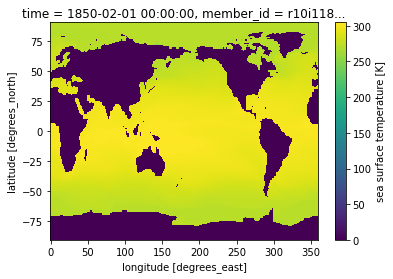

In [10]:
ds_hist_SST.SST.isel(time=0,member_id=0).plot()

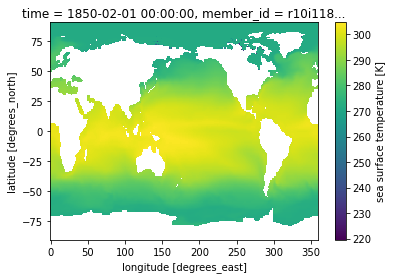

In [11]:
ds_hist_SST=ds_hist_cmip6_SST.where(ds_hist_cmip6_SST['SST'] != 0.)
ds_hist_SST.SST.isel(time=0,member_id=0).plot()

#### 2. Building the mask

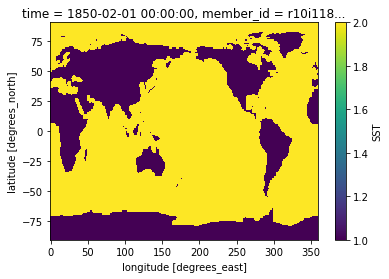

In [12]:
mask_ocean = 2 * np.ones((ds_hist_SST.dims['lat'], ds_hist_cmip6_SST.dims['lon'])) * np.isfinite(ds_hist_SST.SST.isel(time=0,member_id=0))  
mask_land = 1 * np.ones((ds_hist_SST.dims['lat'], ds_hist_cmip6_SST.dims['lon'])) * np.isnan(ds_hist_SST.SST.isel(time=0,member_id=0))  
mask_array = mask_ocean + mask_land
mask_array.plot()

#### 3. Applying the mask for the other variables

In [13]:
ds_hist_PRECT =ds_hist_PRECT.where(mask_array != 1.) # Precipitation 
ds_hist_LHFLX =ds_hist_LHFLX.where(mask_array != 1.) # Latent Heat Flux
ds_hist_SHFLX =ds_hist_SHFLX.where(mask_array != 1.) # Sensible Heat Flux

### Just to make sure that the mask was applied

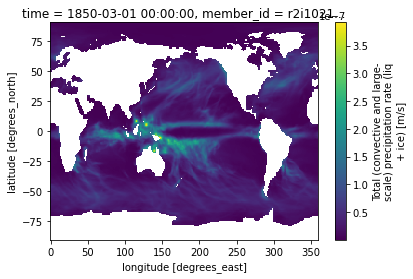

In [14]:
ds_hist_PRECT.PRECT.isel(time=1,member_id=10).plot() # Precipitation 

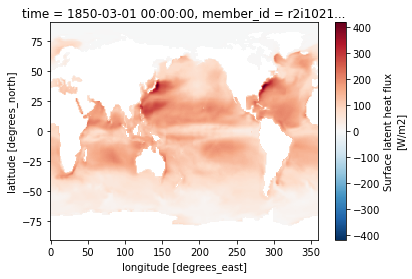

In [15]:
ds_hist_LHFLX.LHFLX.isel(time=1,member_id=10).plot() # Latent Heat Flux 

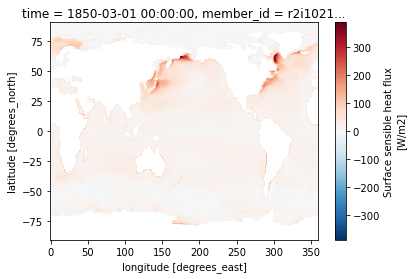

In [16]:
ds_hist_SHFLX.SHFLX.isel(time=1,member_id=10).plot() # Sensible Heat Flux

### One more example...

Text(0.5, 1.0, 'i1231p1f1')

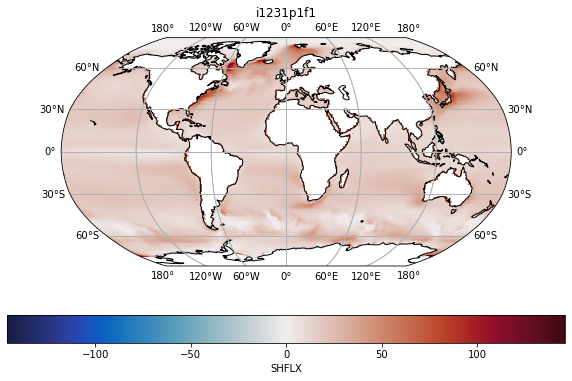

In [17]:
ds_var_1231 = ds_hist_SHFLX.SHFLX.sel(member_id=['r1i1231p1f1','r2i1231p1f1','r3i1231p1f1','r4i1231p1f1','r5i1231p1f1','r6i1231p1f1','r7i1231p1f1','r8i1231p1f1','r9i1231p1f1','r10i1231p1f1']).mean(dim='time')#.plot()
plt.figure(figsize=(10,6));
ax = plt.axes(projection=ccrs.Robinson());
pc = ds_var_1231.mean(dim='member_id').plot.pcolormesh(ax=ax,
                    transform=ccrs.PlateCarree(),
                    cmap=cmocean.cm.balance,
                    x='lon',
                    y='lat',
                    #vmin=-3,
                    #vmax=30,
                    cbar_kwargs={"orientation": "horizontal"})                                    
ax.gridlines(draw_labels=True);
ax.coastlines()
ax.gridlines();
plt.title("i1231p1f1")

### Centralize the South Atlantic 
Need to combine the domain in the east/west direction to centralize the South Atlantic

In [18]:
ilat, flat = 68, 95
ilon1, flon1, ilon2, flon2 = 250, 288, 0, 20
for ifb in range(0,len(fb)):
    print(f'Variable: {fb[ifb]}')
    str=f'sa_ds_{fb[ifb]}=xr.combine_nested([[ds_hist_{fb[ifb]}.isel(lat = slice(ilat,flat),lon = slice(ilon1,flon1)),ds_hist_{fb[ifb]}.isel(lat = slice(ilat,flat),lon = slice(ilon2,flon2))]],concat_dim=[\'lat\',\'lon\'])'
    exec(str)
    str=f'sa_ds_{fb[ifb]}.coords[\'lon\'] = (sa_ds_{fb[ifb]}.coords[\'lon\'] + 180) % 360 - 180' # change the longitudes: -180 0 180
    exec(str)
    str=f'sa_ds_{fb[ifb]} = sa_ds_{fb[ifb]}.sortby(sa_ds_{fb[ifb]}.lon)'
    exec(str)

Variable: LHFLX
Variable: SHFLX
Variable: SST
Variable: PRECT


### Let's test

CPU times: user 269 ms, sys: 12 ms, total: 281 ms
Wall time: 458 ms


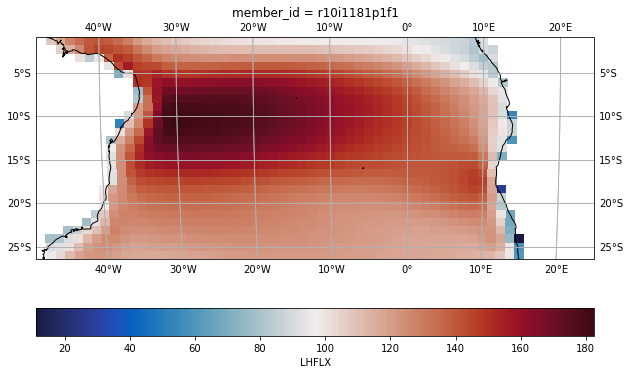

In [19]:
%%time
plt.figure(figsize=(10,6));
ax = plt.axes(projection=ccrs.Robinson());
pc = sa_ds_LHFLX.LHFLX.isel(member_id=0).mean(dim='time').plot.pcolormesh(ax=ax,
                    transform=ccrs.PlateCarree(),
                    cmap=cmocean.cm.balance,
                    x='lon',
                    y='lat',
                    #vmin=290,
                    #vmax=302,
                    cbar_kwargs={"orientation": "horizontal"})                                    
ax.gridlines(draw_labels=True);
ax.coastlines()
ax.gridlines();

<div class="alert alert-block alert-info">
<b>Note:</b> In the figure above, some grid points seem to have remained over the continent, even using SST as a mask. This has some impact especially when we extract the minimum area value.  
</div>

In [20]:
sa_ds_LHFLX.coords['lon']

<xarray.DataArray 'lon' (lon: 58)>
array([-47.5 , -46.25, -45.  , -43.75, -42.5 , -41.25, -40.  , -38.75, -37.5 ,
       -36.25, -35.  , -33.75, -32.5 , -31.25, -30.  , -28.75, -27.5 , -26.25,
       -25.  , -23.75, -22.5 , -21.25, -20.  , -18.75, -17.5 , -16.25, -15.  ,
       -13.75, -12.5 , -11.25, -10.  ,  -8.75,  -7.5 ,  -6.25,  -5.  ,  -3.75,
        -2.5 ,  -1.25,   0.  ,   1.25,   2.5 ,   3.75,   5.  ,   6.25,   7.5 ,
         8.75,  10.  ,  11.25,  12.5 ,  13.75,  15.  ,  16.25,  17.5 ,  18.75,
        20.  ,  21.25,  22.5 ,  23.75])
Coordinates:
  * lon      (lon) float64 -47.5 -46.25 -45.0 -43.75 ... 20.0 21.25 22.5 23.75

### Perfom computations
Calculate area mean, min, max, and rms for the surface temperature of the selected region

In [21]:
%%time
start="1850-01-01"
end="2014-12-31"
for ifb in range(0,len(fb)):
    print(f'Variable: {fb[ifb]}')
    str=f'var_{fb[ifb]} = sa_ds_{fb[ifb]}.{fb[ifb]}.sel(time=slice(start,end))'               # time
    exec(str)
    # Mean
    str=f'var_mean_{fb[ifb]} = var_{fb[ifb]}.mean(dim=(\'lon\',\'lat\')).load()'              # Mean
    exec(str)
    # Maximum
    str=f'var_max_{fb[ifb]} = var_{fb[ifb]}.max(dim=(\'lon\',\'lat\')).load()'                # Maximum
    exec(str)
    # Minimum
    str=f'var_min_{fb[ifb]} = var_{fb[ifb]}.min(dim=(\'lon\',\'lat\')).load()'                # Minimum
    exec(str)
    # RMS
    str=f'var_rms_{fb[ifb]} = np.sqrt((var_{fb[ifb]}**2).mean(dim=[\'lat\',\'lon\'])).load()' # Root Mean Square
    exec(str)
print(f'Done!')

Variable: LHFLX
Variable: SHFLX
Variable: SST
Variable: PRECT
Done!
CPU times: user 2min 32s, sys: 2.68 s, total: 2min 35s
Wall time: 2min 43s


### TODO
Plot some time series to check calculations

### Merge data and save on disk

In [27]:
units=('W/m2','W/m2','K','m/s')
long_name=('Latent Heat Flux','Sensible Heat Flux','Sea Surface Temperature','Total (convective and large-scale) precipitation rate (liq + ice)')
for ifb in range(0,len(fb)):
    print(f'Variable: {fb[ifb]}')
    str=f'ds_out_{fb[ifb]} = xr.merge([var_rms_{fb[ifb]}.rename(\'{fb[ifb]}_rms\'),var_mean_{fb[ifb]}.rename(\'{fb[ifb]}_mean\'),var_max_{fb[ifb]}.rename(\'{fb[ifb]}_max\'),var_min_{fb[ifb]}.rename(\'{fb[ifb]}_min\')])'
    exec(str)
    # TODO: add more attrs e.g., date it was create, by who (name, email), 
    ## improve description, add lat/lon region etc
    str=f'ds_out_{fb[ifb]}.attrs[\'description\'] = \'{long_name[ifb]} ({fb[ifb]} [{units[ifb]}]) statistics for the South Atlantic (47.5W-23.75E and 25.91623S-1.413613S) made by Mauricio Rocha (mauricio.rocha@usp.br).\''
    exec(str)

Variable: LHFLX
Variable: SHFLX
Variable: SST
Variable: PRECT


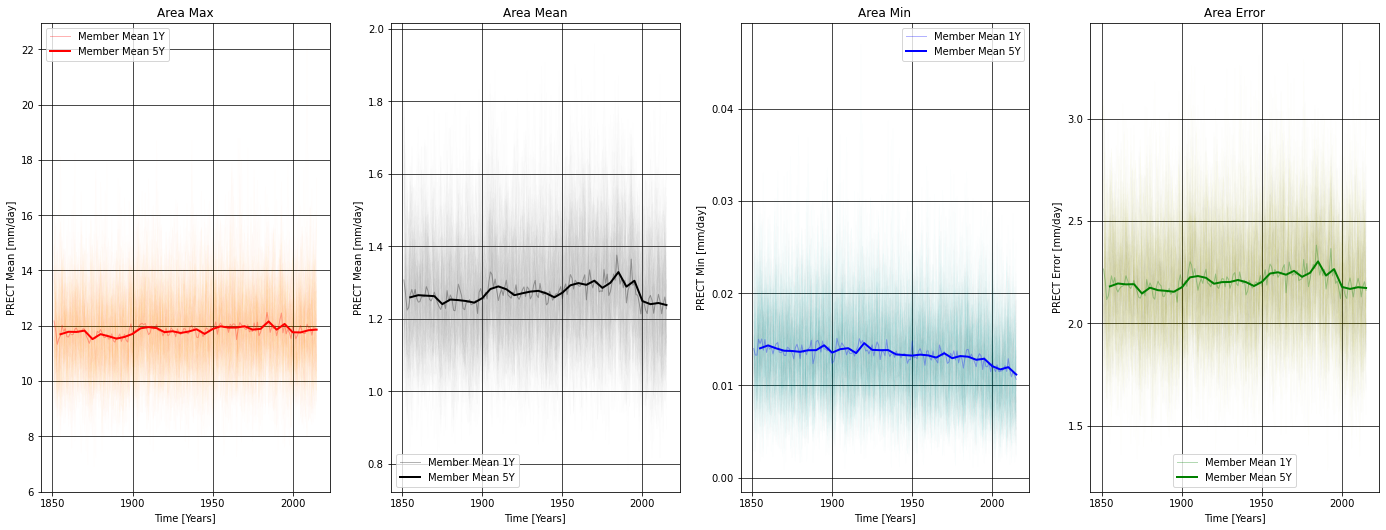

In [45]:
# PRECIPITATION

fig, axes = plt.subplots(1, 4, figsize=(20, 8))
# Maximum
(ds_out_PRECT.PRECT_max.resample(time='1Y', closed='left').mean('time')*86400000).plot.line(ax=axes[0],x="time",color='orange',alpha=0.01,linewidth=1,add_legend=False)
(ds_out_PRECT.PRECT_max.resample(time='1Y', closed='left').mean('time').mean('member_id')*86400000).plot.line(ax=axes[0],x="time",alpha=0.3,color='r',linewidth=1,label='Member Mean 1Y')
(ds_out_PRECT.PRECT_max.resample(time='5Y', closed='left').mean('time').mean('member_id')*86400000).plot.line(ax=axes[0],x="time",color='r',linewidth=2,label='Member Mean 5Y')
axes[0].set_xlabel('Time [Years]')
axes[0].set_ylabel('PRECT Mean [mm/day]')
axes[0].set_title('Area Max')
axes[0].grid(color='k', linestyle='-', linewidth=0.7)
axes[0].legend()
fig.tight_layout(pad=3)

# Mean
(ds_out_PRECT.PRECT_mean.resample(time='1Y', closed='left').mean('time')*86400000).plot.line(ax=axes[1],x="time",color='gray',alpha=0.01,linewidth=1,add_legend=False)
(ds_out_PRECT.PRECT_mean.resample(time='1Y', closed='left').mean('time').mean('member_id')*86400000).plot.line(ax=axes[1],x="time",alpha=0.3,color='k',linewidth=1,label='Member Mean 1Y')
(ds_out_PRECT.PRECT_mean.resample(time='5Y', closed='left').mean('time').mean('member_id')*86400000).plot.line(ax=axes[1],x="time",color='k',linewidth=2,label='Member Mean 5Y')
axes[1].set_xlabel('Time [Years]')
axes[1].set_ylabel('PRECT Mean [mm/day]')
axes[1].set_title('Area Mean')
axes[1].grid(color='k', linestyle='-', linewidth=0.7)
axes[1].legend()

# Minimum
(ds_out_PRECT.PRECT_min.resample(time='1Y', closed='left').mean('time')*86400000).plot.line(ax=axes[2],x="time",color='c',alpha=0.01,linewidth=1,add_legend=False)
(ds_out_PRECT.PRECT_min.resample(time='1Y', closed='left').mean('time').mean('member_id')*86400000).plot.line(ax=axes[2],x="time",alpha=0.3,color='b',linewidth=1,label='Member Mean 1Y')
(ds_out_PRECT.PRECT_min.resample(time='5Y', closed='left').mean('time').mean('member_id')*86400000).plot.line(ax=axes[2],x="time",color='b',linewidth=2,label='Member Mean 5Y')
axes[2].set_xlabel('Time [Years]')
axes[2].set_ylabel('PRECT Min [mm/day]')
axes[2].set_title('Area Min')
axes[2].grid(color='k', linestyle='-', linewidth=0.7)
axes[2].legend()

# root mean square
(ds_out_PRECT.PRECT_rms.resample(time='1Y', closed='left').mean('time')*86400000).plot.line(ax=axes[3],x="time",color='y',alpha=0.01,linewidth=1,add_legend=False)
(ds_out_PRECT.PRECT_rms.resample(time='1Y', closed='left').mean('time').mean('member_id')*86400000).plot.line(ax=axes[3],x="time",alpha=0.3,color='g',linewidth=1,label='Member Mean 1Y')
(ds_out_PRECT.PRECT_rms.resample(time='5Y', closed='left').mean('time').mean('member_id')*86400000).plot.line(ax=axes[3],x="time",color='g',linewidth=2,label='Member Mean 5Y')
axes[3].set_xlabel('Time [Years]')
axes[3].set_ylabel('PRECT Error [mm/day]')
axes[3].set_title('Area Error')
axes[3].grid(color='k', linestyle='-', linewidth=0.7)
axes[3].legend()

plt.show()

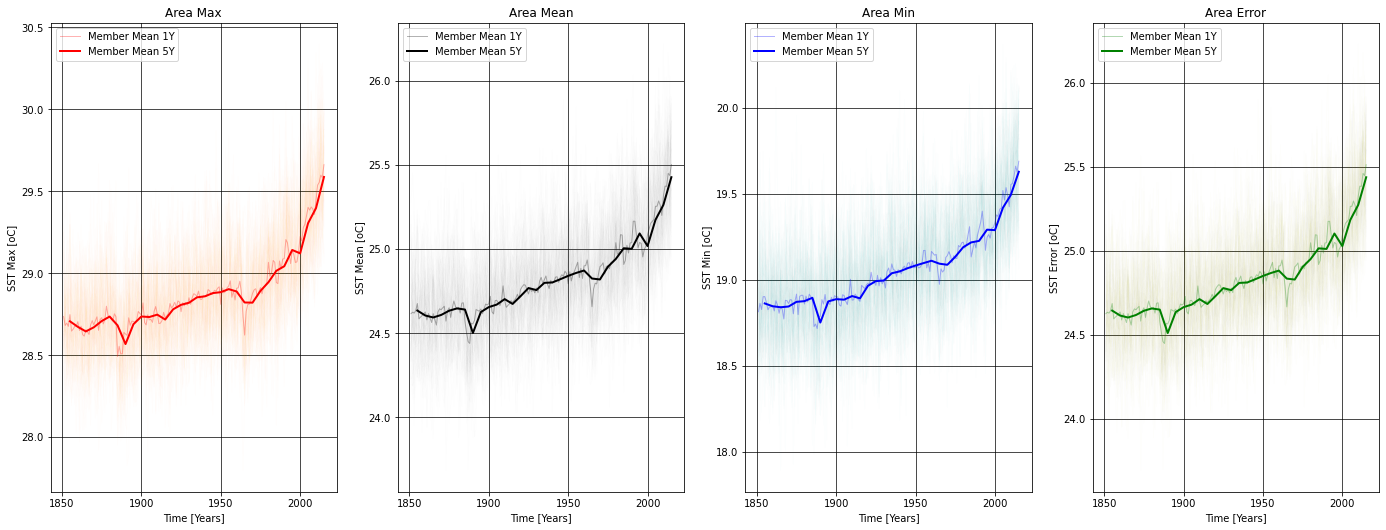

In [43]:
#### SEA SURFACE TEMPERATURE

fig, axes = plt.subplots(1, 4, figsize=(20, 8))
# Maximum
(ds_out_SST.SST_max.resample(time='1Y', closed='left').mean('time')-273.15).plot.line(ax=axes[0],x="time",color='orange',alpha=0.01,linewidth=1,add_legend=False)
(ds_out_SST.SST_max.resample(time='1Y', closed='left').mean('time').mean('member_id')-273.15).plot.line(ax=axes[0],x="time",alpha=0.3,color='r',linewidth=1,label='Member Mean 1Y')
(ds_out_SST.SST_max.resample(time='5Y', closed='left').mean('time').mean('member_id')-273.15).plot.line(ax=axes[0],x="time",color='r',linewidth=2,label='Member Mean 5Y')
axes[0].set_xlabel('Time [Years]')
axes[0].set_ylabel('SST Max [oC]')
axes[0].set_title('Area Max')
axes[0].grid(color='k', linestyle='-', linewidth=0.7)
axes[0].legend()
fig.tight_layout(pad=3)

# Mean
(ds_out_SST.SST_mean.resample(time='1Y', closed='left').mean('time')-273.15).plot.line(ax=axes[1],x="time",color='gray',alpha=0.01,linewidth=1,add_legend=False)
(ds_out_SST.SST_mean.resample(time='1Y', closed='left').mean('time').mean('member_id')-273.15).plot.line(ax=axes[1],x="time",alpha=0.3,color='k',linewidth=1,label='Member Mean 1Y')
(ds_out_SST.SST_mean.resample(time='5Y', closed='left').mean('time').mean('member_id')-273.15).plot.line(ax=axes[1],x="time",color='k',linewidth=2,label='Member Mean 5Y')
axes[1].set_xlabel('Time [Years]')
axes[1].set_ylabel('SST Mean [oC]')
axes[1].set_title('Area Mean')
axes[1].grid(color='k', linestyle='-', linewidth=0.7)
axes[1].legend()

# Minimum
(ds_out_SST.SST_min.resample(time='1Y', closed='left').mean('time')-273.15).plot.line(ax=axes[2],x="time",color='c',alpha=0.01,linewidth=1,add_legend=False)
(ds_out_SST.SST_min.resample(time='1Y', closed='left').mean('time').mean('member_id')-273.15).plot.line(ax=axes[2],x="time",alpha=0.3,color='b',linewidth=1,label='Member Mean 1Y')
(ds_out_SST.SST_min.resample(time='5Y', closed='left').mean('time').mean('member_id')-273.15).plot.line(ax=axes[2],x="time",color='b',linewidth=2,label='Member Mean 5Y')
axes[2].set_xlabel('Time [Years]')
axes[2].set_ylabel('SST Min [oC]')
axes[2].set_title('Area Min')
axes[2].grid(color='k', linestyle='-', linewidth=0.7)
axes[2].legend()

# root mean square
(ds_out_SST.SST_rms.resample(time='1Y', closed='left').mean('time')-273.15).plot.line(ax=axes[3],x="time",color='y',alpha=0.01,linewidth=1,add_legend=False)
(ds_out_SST.SST_rms.resample(time='1Y', closed='left').mean('time').mean('member_id')-273.15).plot.line(ax=axes[3],x="time",alpha=0.3,color='g',linewidth=1,label='Member Mean 1Y')
(ds_out_SST.SST_rms.resample(time='5Y', closed='left').mean('time').mean('member_id')-273.15).plot.line(ax=axes[3],x="time",color='g',linewidth=2,label='Member Mean 5Y')
axes[3].set_xlabel('Time [Years]')
axes[3].set_ylabel('SST Error [oC]')
axes[3].set_title('Area Error')
axes[3].grid(color='k', linestyle='-', linewidth=0.7)
axes[3].legend()

plt.show()

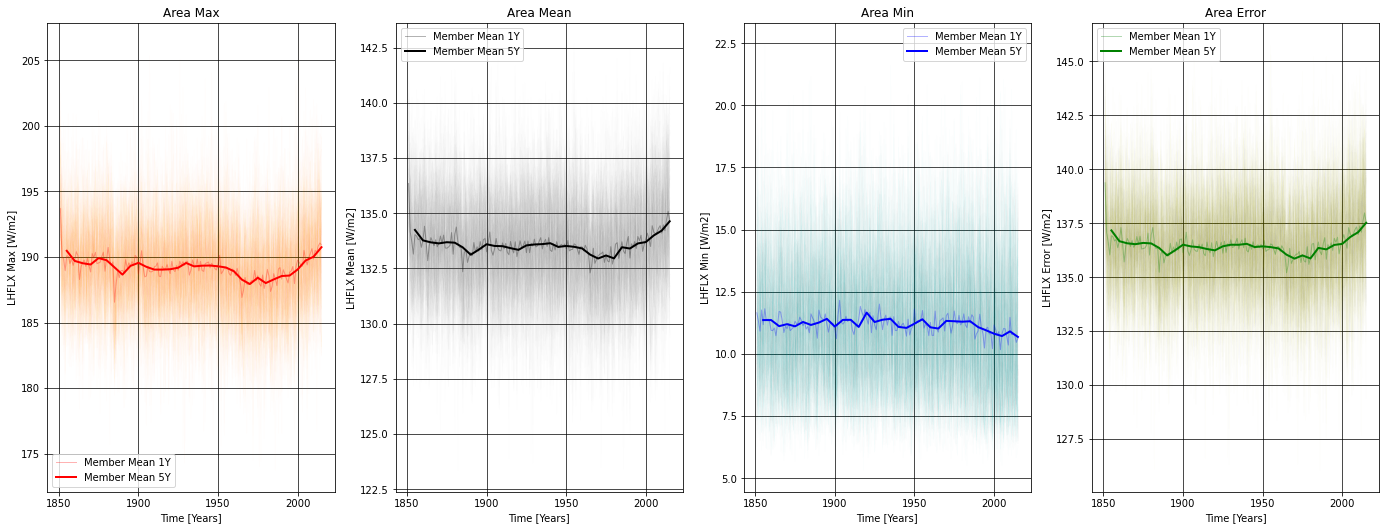

In [42]:
#### LATENT HEAT FLUX

fig, axes = plt.subplots(1, 4, figsize=(20, 8))
# Maximum
ds_out_LHFLX.LHFLX_max.resample(time='1Y', closed='left').mean('time').plot.line(ax=axes[0],x="time",color='orange',alpha=0.01,linewidth=1,add_legend=False)
(ds_out_LHFLX.LHFLX_max.resample(time='1Y', closed='left').mean('time').mean('member_id')).plot.line(ax=axes[0],x="time",alpha=0.3,color='r',linewidth=1,label='Member Mean 1Y')
(ds_out_LHFLX.LHFLX_max.resample(time='5Y', closed='left').mean('time').mean('member_id')).plot.line(ax=axes[0],x="time",color='r',linewidth=2,label='Member Mean 5Y')
axes[0].set_xlabel('Time [Years]')
axes[0].set_ylabel('LHFLX Max [W/m2]')
axes[0].set_title('Area Max')
axes[0].grid(color='k', linestyle='-', linewidth=0.7)
axes[0].legend()
fig.tight_layout(pad=3)

# Mean
ds_out_LHFLX.LHFLX_mean.resample(time='1Y', closed='left').mean('time').plot.line(ax=axes[1],x="time",color='gray',alpha=0.01,linewidth=1,add_legend=False)
(ds_out_LHFLX.LHFLX_mean.resample(time='1Y', closed='left').mean('time').mean('member_id')).plot.line(ax=axes[1],x="time",alpha=0.3,color='k',linewidth=1,label='Member Mean 1Y')
(ds_out_LHFLX.LHFLX_mean.resample(time='5Y', closed='left').mean('time').mean('member_id')).plot.line(ax=axes[1],x="time",color='k',linewidth=2,label='Member Mean 5Y')
axes[1].set_xlabel('Time [Years]')
axes[1].set_ylabel('LHFLX Mean [W/m2]')
axes[1].set_title('Area Mean')
axes[1].grid(color='k', linestyle='-', linewidth=0.7)
axes[1].legend()

# Minimum
ds_out_LHFLX.LHFLX_min.resample(time='1Y', closed='left').mean('time').plot.line(ax=axes[2],x="time",color='c',alpha=0.01,linewidth=1,add_legend=False)
(ds_out_LHFLX.LHFLX_min.resample(time='1Y', closed='left').mean('time').mean('member_id')).plot.line(ax=axes[2],x="time",alpha=0.3,color='b',linewidth=1,label='Member Mean 1Y')
(ds_out_LHFLX.LHFLX_min.resample(time='5Y', closed='left').mean('time').mean('member_id')).plot.line(ax=axes[2],x="time",color='b',linewidth=2,label='Member Mean 5Y')
axes[2].set_xlabel('Time [Years]')
axes[2].set_ylabel('LHFLX Min [W/m2]')
axes[2].set_title('Area Min')
axes[2].grid(color='k', linestyle='-', linewidth=0.7)
axes[2].legend()

# root mean square
ds_out_LHFLX.LHFLX_rms.resample(time='1Y', closed='left').mean('time').plot.line(ax=axes[3],x="time",color='y',alpha=0.01,linewidth=1,add_legend=False)
(ds_out_LHFLX.LHFLX_rms.resample(time='1Y', closed='left').mean('time').mean('member_id')).plot.line(ax=axes[3],x="time",alpha=0.3,color='g',linewidth=1,label='Member Mean 1Y')
(ds_out_LHFLX.LHFLX_rms.resample(time='5Y', closed='left').mean('time').mean('member_id')).plot.line(ax=axes[3],x="time",color='g',linewidth=2,label='Member Mean 5Y')
axes[3].set_xlabel('Time [Years]')
axes[3].set_ylabel('LHFLX Error [W/m2]')
axes[3].set_title('Area Error')
axes[3].grid(color='k', linestyle='-', linewidth=0.7)
axes[3].legend()

plt.show()

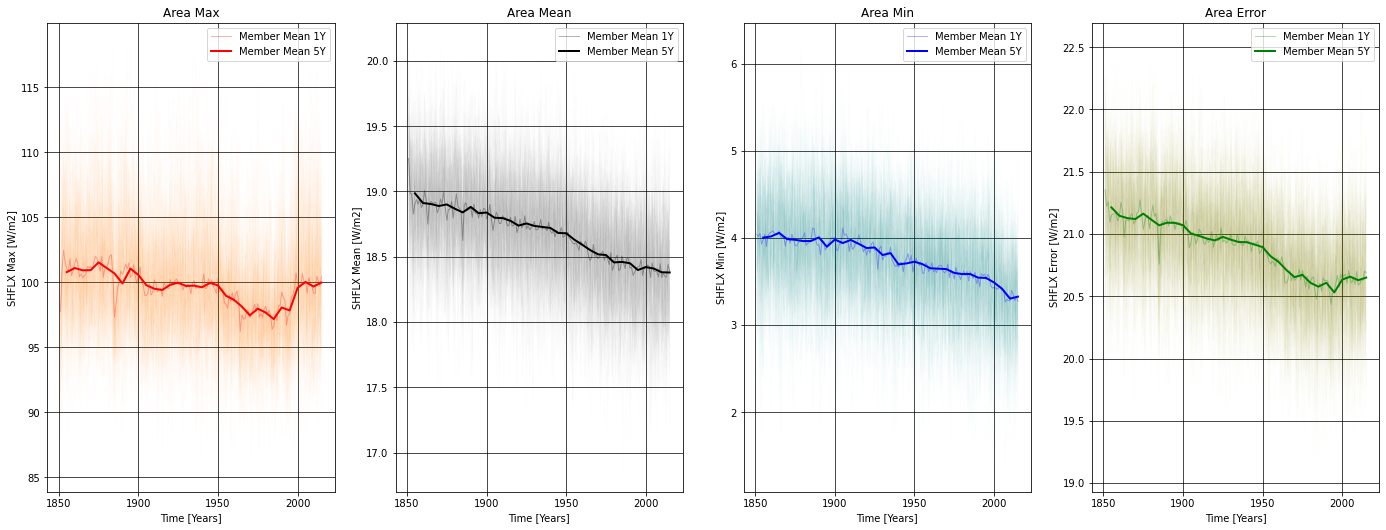

In [44]:
#### SENSIBLE HEAT FLUX

fig, axes = plt.subplots(1, 4, figsize=(20, 8))
# Maximum
ds_out_SHFLX.SHFLX_max.resample(time='1Y', closed='left').mean('time').plot.line(ax=axes[0],x="time",color='orange',alpha=0.01,linewidth=1,add_legend=False)
(ds_out_SHFLX.SHFLX_max.resample(time='1Y', closed='left').mean('time').mean('member_id')).plot.line(ax=axes[0],x="time",alpha=0.3,color='r',linewidth=1,label='Member Mean 1Y')
(ds_out_SHFLX.SHFLX_max.resample(time='5Y', closed='left').mean('time').mean('member_id')).plot.line(ax=axes[0],x="time",color='r',linewidth=2,label='Member Mean 5Y')
axes[0].set_xlabel('Time [Years]')
axes[0].set_ylabel('SHFLX Max [W/m2]')
axes[0].set_title('Area Max')
axes[0].grid(color='k', linestyle='-', linewidth=0.7)
axes[0].legend()
fig.tight_layout(pad=3)

# Mean
ds_out_SHFLX.SHFLX_mean.resample(time='1Y', closed='left').mean('time').plot.line(ax=axes[1],x="time",color='gray',alpha=0.01,linewidth=1,add_legend=False)
(ds_out_SHFLX.SHFLX_mean.resample(time='1Y', closed='left').mean('time').mean('member_id')).plot.line(ax=axes[1],x="time",alpha=0.3,color='k',linewidth=1,label='Member Mean 1Y')
(ds_out_SHFLX.SHFLX_mean.resample(time='5Y', closed='left').mean('time').mean('member_id')).plot.line(ax=axes[1],x="time",color='k',linewidth=2,label='Member Mean 5Y')
axes[1].set_xlabel('Time [Years]')
axes[1].set_ylabel('SHFLX Mean [W/m2]')
axes[1].set_title('Area Mean')
axes[1].grid(color='k', linestyle='-', linewidth=0.7)
axes[1].legend()

# Minimum
ds_out_SHFLX.SHFLX_min.resample(time='1Y', closed='left').mean('time').plot.line(ax=axes[2],x="time",color='c',alpha=0.01,linewidth=1,add_legend=False)
(ds_out_SHFLX.SHFLX_min.resample(time='1Y', closed='left').mean('time').mean('member_id')).plot.line(ax=axes[2],x="time",alpha=0.3,color='b',linewidth=1,label='Member Mean 1Y')
(ds_out_SHFLX.SHFLX_min.resample(time='5Y', closed='left').mean('time').mean('member_id')).plot.line(ax=axes[2],x="time",color='b',linewidth=2,label='Member Mean 5Y')
axes[2].set_xlabel('Time [Years]')
axes[2].set_ylabel('SHFLX Min [W/m2]')
axes[2].set_title('Area Min')
axes[2].grid(color='k', linestyle='-', linewidth=0.7)
axes[2].legend()

# root mean square
ds_out_SHFLX.SHFLX_rms.resample(time='1Y', closed='left').mean('time').plot.line(ax=axes[3],x="time",color='y',alpha=0.01,linewidth=1,add_legend=False)
(ds_out_SHFLX.SHFLX_rms.resample(time='1Y', closed='left').mean('time').mean('member_id')).plot.line(ax=axes[3],x="time",alpha=0.3,color='g',linewidth=1,label='Member Mean 1Y')
(ds_out_SHFLX.SHFLX_rms.resample(time='5Y', closed='left').mean('time').mean('member_id')).plot.line(ax=axes[3],x="time",color='g',linewidth=2,label='Member Mean 5Y')
axes[3].set_xlabel('Time [Years]')
axes[3].set_ylabel('SHFLX Error [W/m2]')
axes[3].set_title('Area Error')
axes[3].grid(color='k', linestyle='-', linewidth=0.7)
axes[3].legend()

plt.show()

### Let's save the data in netcdf format

In [32]:
# create a directory on scratch to save the output
for ifb in range(0,len(fb)):
    print(f'Variable: {fb[ifb]}')
    str=f'path = \'/glade/scratch/mauricio/LENS2_south_atlantic/{fb[ifb]}/\'.format(getpass.getuser())'
    exec(str)
    str=f'os.system(\'mkdir -p \'+path)'
    exec(str)
    str=f'ds_out_{fb[ifb]}.to_netcdf(path+\'{fb[ifb]}_stats.nc\')'
    exec(str)

Variable: LHFLX
Variable: SHFLX
Variable: SST
Variable: PRECT


In [ ]:
cluster.close()
client.close()